In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from skimage.io import imsave,imread
import skimage
import skimage.feature
import skimage.viewer
import sys
from scipy import ndimage as ndi
from skimage.morphology import opening,remove_small_objects,closing,dilation,erosion
from skimage.measure import regionprops,label

/Users/christina.bukas/opt/anaconda3/envs/imaging/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Viewer requires Qt
  


# Load czi file and extract wells from it. Generate jpg files.

In [38]:
import czifile
img = czifile.imread('../../datasets/organoids images/02-10-2021_Organoids_BF_10X-E4-Create Image Subset-Stitching.czi')

#img = czifile.imread('Organoids human fibroblasts/Organoids 96-well cytokines + human-Extended Depth of Focus-02-Create Image Subset-03.czi')
print(img.shape)
#corrected = czifile.imread('Organoids human fibroblasts/Organoids 96-well cytokines + human-Extended Depth of Focus-02-Create Image Subset-03-Shading Correction-06.czi')
#print(corrected.shape)
img=img[0,0,0,:,:,:,0]


(1, 1, 1, 10, 12501, 11529, 1)


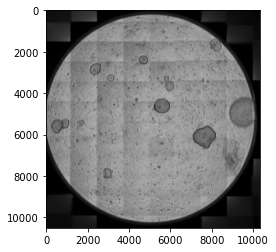

In [39]:
plt.imshow(img[5,500:11000,170:10500], cmap='gray') # crop area to show else black
plt.show()

In [7]:
for w in range(10):
    
    newpath = './Organoids human fibroblasts'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    image = img[w,:,:]
    index = np.where(image>50)
    x,y = min(index[0]),min(index[1])
#     for ch in range(8):  # for the original image, each well has 8 stacks
    image = img[w,:,:]
    image = image[::10,::10]
    #corrected_img = corrected[w,0,x:x+5200,y:y+5200,0]
    #corrected_img = corrected_img[::10,::10]
    image = ((image-image.min())/(image.max()-image.min())*255).astype(np.uint8)
    #corrected_img = ((corrected_img-corrected_img.min())/(corrected_img.max()-corrected_img.min())*255).astype(np.uint8)
    imsave(newpath+'/slice{}.jpg'.format(w),image)

In [40]:
type(img)
img_orig = np.copy(img)

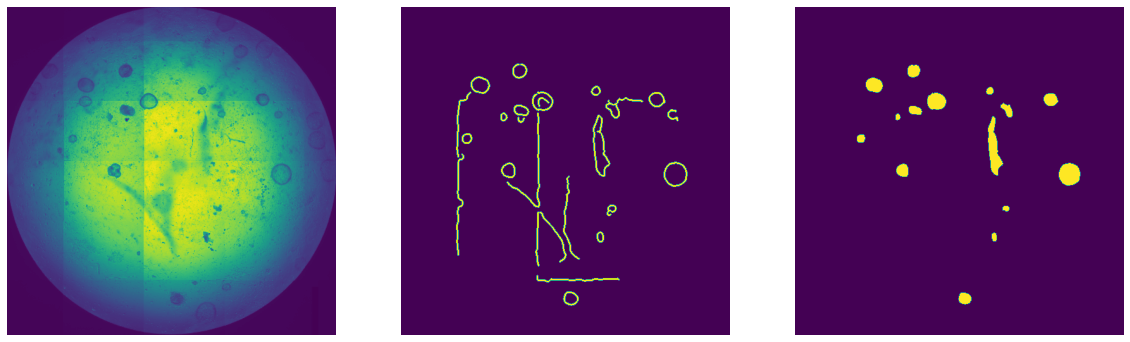

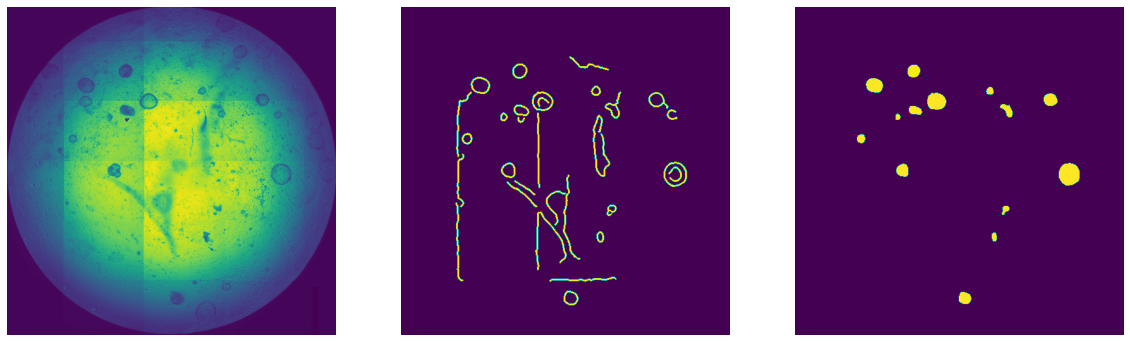

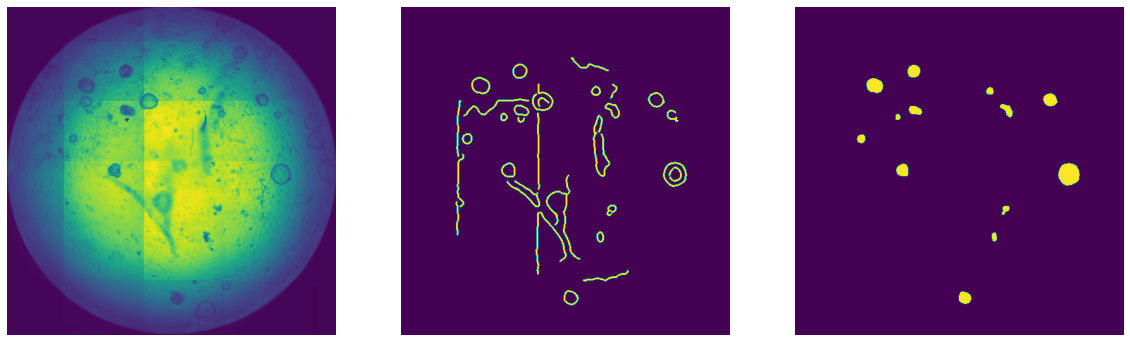

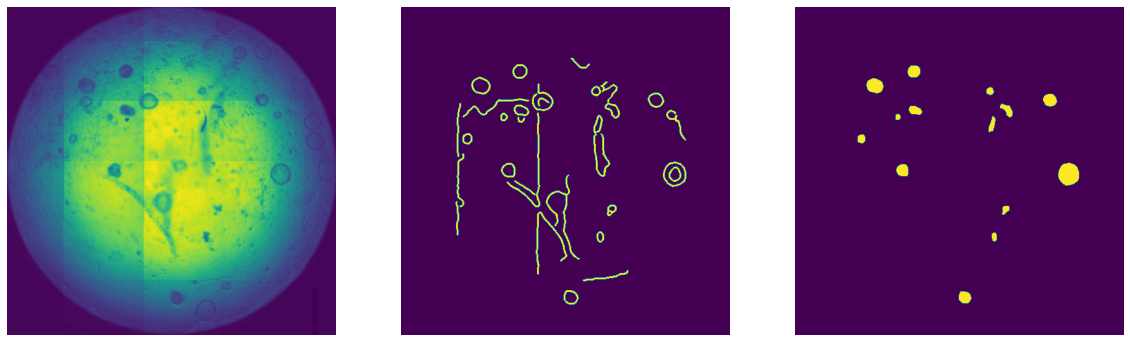

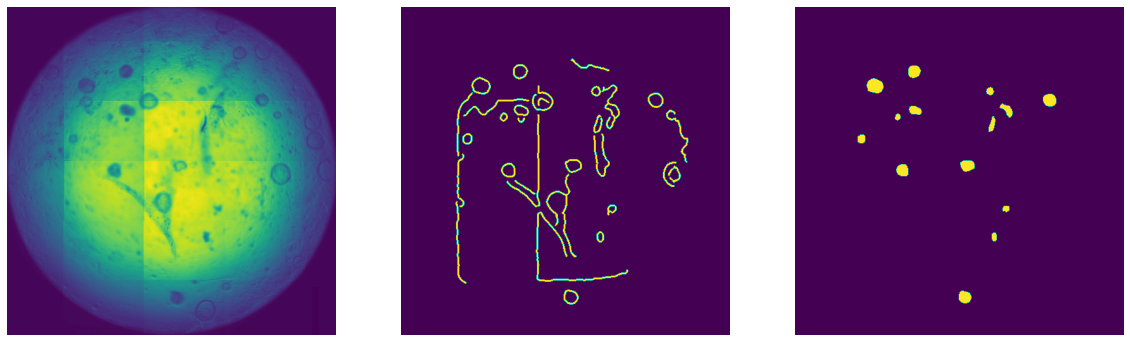

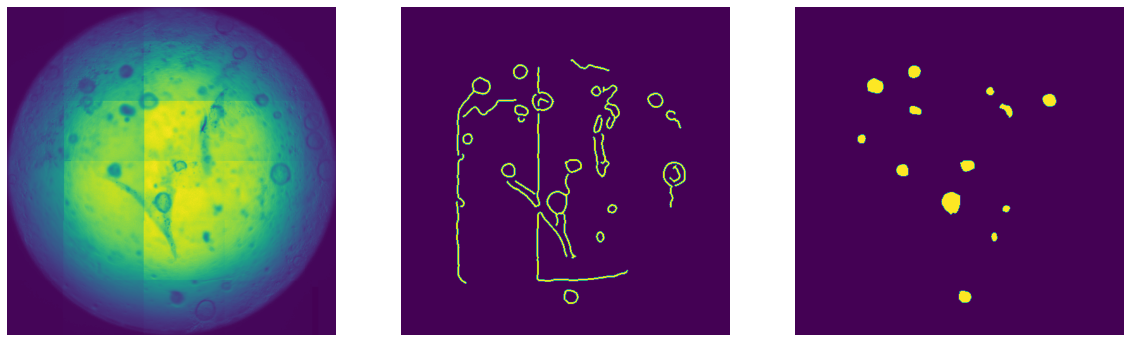

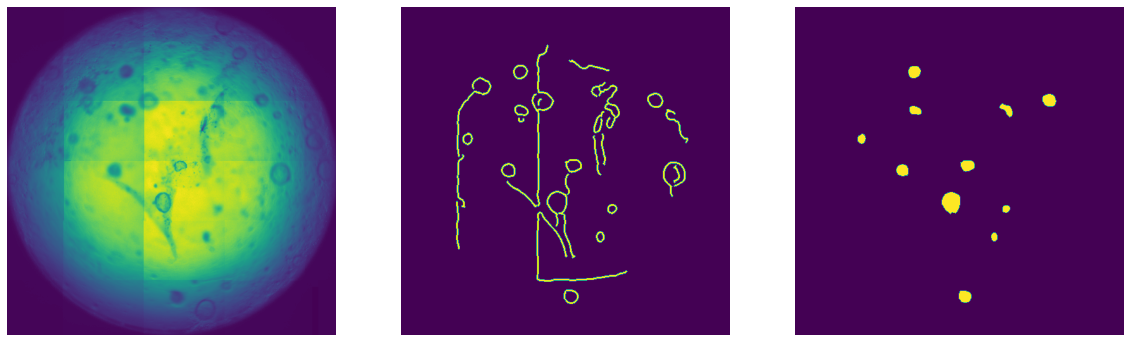

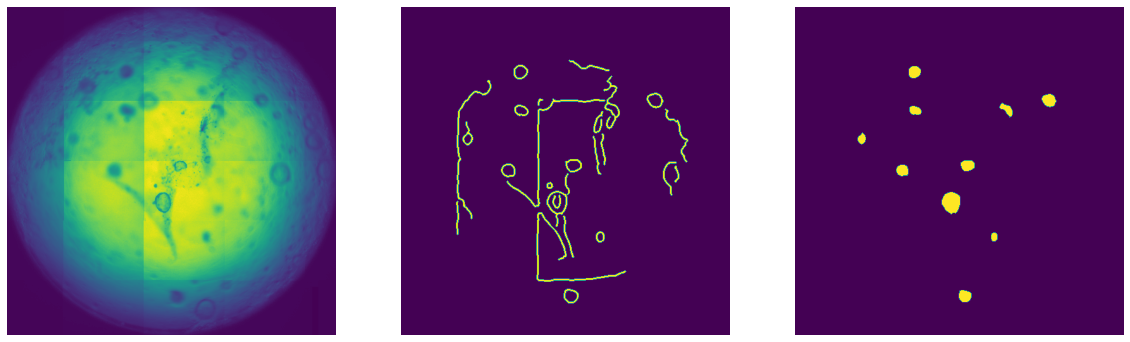

In [46]:
from skimage.transform import resize

res = np.zeros((520,520)).astype(bool)
seg = []
img = []
for j in range(8):
    original_image = plt.imread('example_data/well0{}.jpg'.format(j))
    #image = img_orig[j,500:11000,170:10500]
    image = original_image[::10,::10] # image[::10,::10]
    #image = resize(image, (520,520))
    img.append(image)
    mask = np.where(image<20,False,True)  # 20 is manually selected

    edges = skimage.feature.canny(
        image=image,
        sigma=3.5,#3,
        low_threshold=10,#10,
        high_threshold=35,#25,
        mask = mask
    )
    edges = ndi.binary_dilation(edges)   # dilation is necessary for closing unconneted circle

    filled = ndi.binary_fill_holes(edges)
    filled = erosion(filled)             # remove noise
    filled = erosion(filled)

    region = regionprops(label(filled))
    for prop in region:
        if prop.area > 5000:             # sometimes due to the tiling problem, some grids will be cosidered as closed area and filled in 
            filled[prop.coords] = 0
            
    filled = remove_small_objects(filled,40)
    seg.append(filled)
    res = res | filled
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(edges)
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(filled)
    plt.show()

In [ ]:
# Canny edge detector parameters with slider
# viewer = skimage.viewer.ImageViewer(image=image)

# canny_plugin = skimage.viewer.plugins.Plugin(image_filter=skimage.feature.canny)
# canny_plugin.name = "Canny Filter Plugin"

# canny_plugin += skimage.viewer.widgets.Slider(
#     name="sigma", low=0.0, high=7.0, value=1.0
# )
# canny_plugin += skimage.viewer.widgets.Slider(
#     name="low_threshold", low=0.0, high=255, value=2
# )
# canny_plugin += skimage.viewer.widgets.Slider(
#     name="high_threshold", low=0.0, high=255, value=2
# )

# viewer += canny_plugin
# viewer.show()

# Corrected image

In [ ]:
original_image = plt.imread('Two Test Wells_tile_z_newtemplate_V2_stitched_5x_ef-Split Scenes-02.jpg')
corrected_image = plt.imread('V2_stitched_5x_ef-Split Scenes-02-Shading Correction-14.jpg')
print(original_image.shape)
print(corrected_image.shape)

In [ ]:
corrected_image = 0.2125*corrected_image[::10,::10,0] + 0.7154*corrected_image[::10,::10,1] + 0.0721*corrected_image[::10,::10,2]
image = 0.2125*original_image[::10,::10,0] + 0.7154*original_image[::10,::10,1] + 0.0721*original_image[::10,::10,2]
print(image.shape)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(corrected_image)
plt.subplot(1,2,2)
plt.imshow(image)
plt.show()

In [ ]:
# first edge detector for the original image
mask = np.where((image<20),False,True)
edges = skimage.feature.canny(
    image=image,
    sigma=2.5,
    low_threshold=3,
    high_threshold=20,
    mask=mask
)
edges = ndi.binary_dilation(edges)

filled = ndi.binary_fill_holes(edges)
filled = erosion(filled)
filled = erosion(filled)

# region = regionprops(label(filled))
# for prop in region:
#     if prop.area > 20000:
#         filled[filled==prop.label] = 0

filled = remove_small_objects(filled,40)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.imshow(filled,alpha=0.3)
plt.subplot(1,3,2)
plt.imshow(edges)
plt.subplot(1,3,3)
plt.imshow(filled)
plt.show()

In [ ]:
# second edge detector for corrected image
mask = np.where((image>20)&(image<150),True,False)
mask=erosion(mask)
edges2 = skimage.feature.canny(
    image=corrected_image,
    sigma=2.5,
    low_threshold=5,
    high_threshold=30,
    mask=mask
)
edges2 = ndi.binary_dilation(edges2)

filled2 = ndi.binary_fill_holes(edges2)
filled2 = erosion(filled2)
filled2 = erosion(filled2)

# region = regionprops(label(filled2))
# for prop in region:
#     if prop.area > 20000:
#         filled2[filled2==prop.label] = 0

filled2 = remove_small_objects(filled2,40)

final = filled2+filled

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.imshow(filled2,alpha=0.3)
plt.subplot(1,3,2)
plt.imshow(edges2)
plt.subplot(1,3,3)
plt.imshow(final)
plt.show()